/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/374 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/339M [00:00<?, ?B/s]

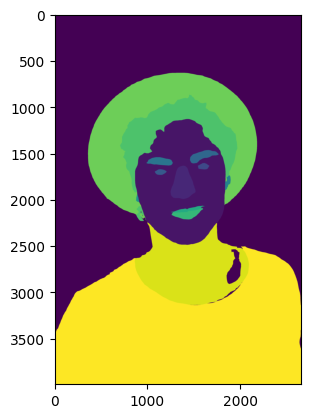

In [1]:
import torch
from torch import nn
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation

from PIL import Image
import matplotlib.pyplot as plt
import requests

# convenience expression for automatically determining device
device = (
    "cuda"
    # Device for NVIDIA or AMD GPUs
    if torch.cuda.is_available()
    else "mps"
    # Device for Apple Silicon (Metal Performance Shaders)
    if torch.backends.mps.is_available()
    else "cpu"
)

# load models
image_processor = SegformerImageProcessor.from_pretrained("jonathandinu/face-parsing")
model = SegformerForSemanticSegmentation.from_pretrained("jonathandinu/face-parsing")
model.to(device)

# expects a PIL.Image or torch.Tensor
url = "https://images.unsplash.com/photo-1539571696357-5a69c17a67c6"
image = Image.open(requests.get(url, stream=True).raw)

# run inference on image
inputs = image_processor(images=image, return_tensors="pt").to(device)
outputs = model(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, ~height/4, ~width/4)

# resize output to match input image dimensions
upsampled_logits = nn.functional.interpolate(logits,
                size=image.size[::-1], # H x W
                mode='bilinear',
                align_corners=False)

# get label masks
labels = upsampled_logits.argmax(dim=1)[0]

# move to CPU to visualize in matplotlib
labels_viz = labels.cpu().numpy()
plt.imshow(labels_viz)
plt.show()